# Capstone Project Flask UI

Pada capstone ini anda diminta untuk membangun sebuah Flask UI sederhana yang berisi beberapa tampilan plot dari skeleton yang sudah disediakan dan satu plot tambahan berdasarkan analisis anda.

File ini dapat dimanfaatkan untuk membantu anda dalam proses wrangling dan visualization. Apabila proses wrangling sudah tepat dan hasil visualisasi sudah sesuai dengan ketentuan, anda dapat memindahkan kembali kode program yang sudah anda lengkapi ke dalam file `app.py`.

## Data Preprocessing

**Import library**

In [1]:
from flask import Flask, render_template
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
import base64

**Load data**

Bacalah file `googleplaystore.csv` data dan simpan ke objek dataframe dengan nama playstore

In [2]:
playstore = pd.read_csv('data/googleplaystore.csv')
playstore.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


**Data Cleansing** 

**_Task 1:_** Hapus data yang duplikat berdasarkan kolom App, dengan tetap keep data pertama (hint : gunakan parameter subset)

In [3]:
playstore['App'].duplicated().sum()

1181

In [4]:
playstore.shape

(10841, 13)

In [5]:
playstore.drop_duplicates(subset = 'App', keep='first',inplace=True) 

In [6]:
playstore['App'].duplicated().sum()

0

Bagian ini untuk menghapus row 10472 karena nilai data tersebut tidak tersimpan pada kolom yang benar

In [7]:
playstore.drop([10472], inplace=True)

**_Task 2:_** Cek tipe data kolom Category. Jika masih tersimpan dengan format tipe data yang salah, ubah ke tipe data yang sesuai


In [8]:
playstore['Category'].dtypes

dtype('O')

In [9]:
playstore.Category = playstore.Category.astype('category')

In [10]:
playstore['Category'].dtypes

CategoricalDtype(categories=['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
                  'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
                  'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FAMILY',
                  'FINANCE', 'FOOD_AND_DRINK', 'GAME', 'HEALTH_AND_FITNESS',
                  'HOUSE_AND_HOME', 'LIBRARIES_AND_DEMO', 'LIFESTYLE',
                  'MAPS_AND_NAVIGATION', 'MEDICAL', 'NEWS_AND_MAGAZINES',
                  'PARENTING', 'PERSONALIZATION', 'PHOTOGRAPHY',
                  'PRODUCTIVITY', 'SHOPPING', 'SOCIAL', 'SPORTS', 'TOOLS',
                  'TRAVEL_AND_LOCAL', 'VIDEO_PLAYERS', 'WEATHER'],
, ordered=False)

**_Task 3:_** Pada kolom Installs Buang tanda koma(,) dan tanda tambah(+) kemudian ubah tipe data menjadi integer

In [11]:
playstore.Installs = playstore.Installs.apply(lambda x: x.replace(',',''))
playstore.Installs = playstore.Installs.apply(lambda x: x.replace('+',''))

In [12]:
playstore.Installs

0           10000
1          500000
2         5000000
3        50000000
4          100000
           ...   
10836        5000
10837         100
10838        1000
10839        1000
10840    10000000
Name: Installs, Length: 9659, dtype: object

Bagian ini untuk merapikan kolom Size, Anda tidak perlu mengubah apapun di bagian ini

In [13]:
playstore['Size'].replace('Varies with device', np.nan, inplace = True ) 
playstore.Size = (playstore.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
             playstore.Size.str.extract(r'[\d\.]+([kM]+)', expand=False)
            .fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))
playstore['Size'].fillna(playstore.groupby('Category')['Size'].transform('mean'),inplace = True)


**_Task 4:_** Pada kolom Price, buang karakater $ pada nilai Price lalu ubah tipe datanya menjadi float

In [14]:
playstore.Price = playstore.Price.apply(lambda x: x.replace('$',''))
playstore.Price = playstore.Price.astype('float64','')
playstore.Price

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
10836    0.0
10837    0.0
10838    0.0
10839    0.0
10840    0.0
Name: Price, Length: 9659, dtype: float64

Ubah tipe data Reviews, Size, Installs ke dalam tipe data integer

In [15]:
##code here
playstore[["Reviews", "Size", "Installs"]] = \
playstore[["Reviews", "Size", "Installs"]].astype('int64')
playstore.dtypes

App                 object
Category          category
Rating             float64
Reviews              int64
Size                 int64
Installs             int64
Type                object
Price              float64
Content Rating      object
Genres              object
Last Updated        object
Current Ver         object
Android Ver         object
dtype: object

## Data Wrangling

In [16]:
df2 = playstore.copy()

In [17]:
df2['App'].duplicated().sum()

0

**_Task 5:_** Dataframe top_category dibuat untuk menyimpan frekuensi aplikasi untuk setiap Category. 
Gunakan crosstab untuk menghitung frekuensi aplikasi di setiap category kemudian gunakan `Jumlah`
sebagai nama kolom dan urutkan nilai frekuensi dari nilai yang paling banyak. Terakhir reset index dari dataframe top_category.

In [18]:
top_category = pd.crosstab(
    index=df2['Category'],
    columns='App',
    values=df2['App'],
    aggfunc='count',
).sort_values(by='App',ascending=False ).reset_index().rename({"App": "Jumlah"}, axis=1)
top_category

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395
5,PERSONALIZATION,376
6,PRODUCTIVITY,374
7,LIFESTYLE,369
8,FINANCE,345
9,SPORTS,325


top_category2 = df2.groupby('Category').count()[['App']].sort_values('App', ascending=False).reset_index().head()
type(top_category2)

In [19]:
top_category.head()

col_0,Category,Jumlah
0,FAMILY,1832
1,GAME,959
2,TOOLS,827
3,BUSINESS,420
4,MEDICAL,395


**_Task 6:_** Ini adalah bagian untuk melengkapi konten value box 
most category mengambil nama category paling banyak mengacu pada dataframe `top_category`
total mengambil frekuensi/jumlah category paling banyak mengacu pada dataframe `top_category`

In [20]:
most_categories = top_category.Category.iloc[0]
total = top_category.Jumlah.iloc[0]

In [21]:
most_categories

'FAMILY'

`rev_table` adalah tabel yang berisi 10 aplikasi yang paling banyak direview oleh pengguna.
Silahkan melakukan agregasi data yang tepat menggunakan `groupby` untuk menampilkan 10 aplikasi yang diurutkan berdasarkan jumlah Review pengguna. 

Tabel yang ditampilkan terdiri dari 4 kolom yaitu nama Category, nama App, total Reviews, dan rata-rata Rating.
Pindahkan kode wrangling yang disimpan dalam variable `rev_table` pada `blank code` yang telah di chaining dengan kode `.to_html`.

In [22]:
rev_table = df2.groupby(['Category','App']).agg({'Reviews': 'sum',
                                    'Rating': 'mean'
                                   }).round(1).sort_values(by='Reviews', ascending=False).reset_index().head(10)

Apabila menuliskan kode program yang tepat maka hasil wrangling adalah sebagai berikut :

In [23]:
rev_table

,Category,App,Reviews,Rating
0,SOCIAL,Facebook,78158306,4.1
1,COMMUNICATION,WhatsApp Messenger,69119316,4.4
2,SOCIAL,Instagram,66577313,4.5
3,COMMUNICATION,Messenger – Text and Video Chat for Free,56642847,4.0
4,GAME,Clash of Clans,44891723,4.6
5,TOOLS,Clean Master- Space Cleaner & Antivirus,42916526,4.7
6,GAME,Subway Surfers,27722264,4.5
7,VIDEO_PLAYERS,YouTube,25655305,4.3
8,TOOLS,"Security Master - Antivirus, VPN, AppLock, Boo...",24900999,4.7
9,GAME,Clash Royale,23133508,4.6


In [24]:
rev_table.to_html('rev_table.html')

## Data Visualization

**Membuat Bar Plot**

**_Task 7:_** 
Lengkapi tahap agregasi untuk membuat dataframe yang mengelompokkan aplikasi berdasarkan Category.
Buatlah bar plot dimana axis x adalah nama Category dan axis y adalah jumlah aplikasi pada setiap kategori, kemudian urutkan dari jumlah terbanyak

C:\Users\USER\AppData\Local\Temp/ipykernel_9056/629009927.py:11: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.barh(X, Y, color=my_colors)


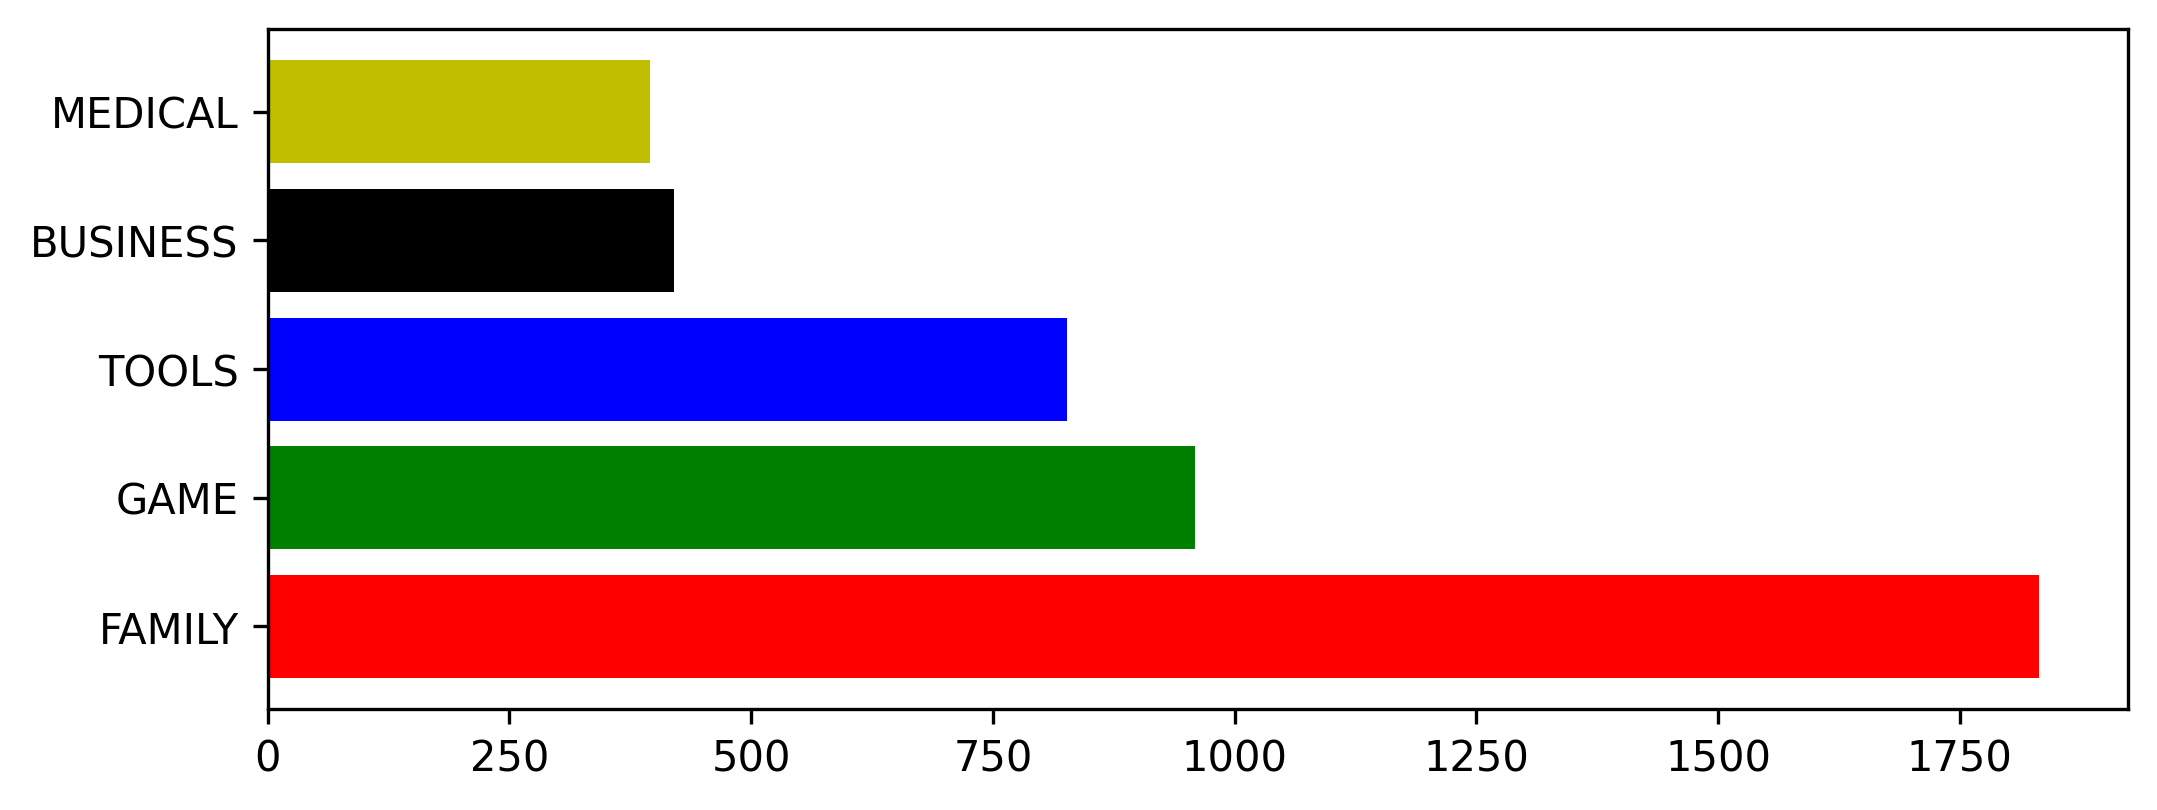

In [25]:
cat_order = df2.groupby('Category').agg({
'App' : 'count'
 }).rename({'App':'Total'}, axis=1).sort_values('Total',ascending=False).head()
X = cat_order.index
Y = cat_order['Total']
my_colors = 'rgbkymc'
# bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8,3),dpi=300)
fig.add_subplot()
# bagian ini digunakan untuk membuat bar plot
plt.barh(X, Y, color=my_colors)
# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('cat_order.png',bbox_inches="tight") 

**Membuat Scatter Plot**

**_Task 8:_** Buatlah scatter plot untuk menampilkan hubungan dan persebaran apalikasi dilihat dari Review vs Rating.
Ukuran scatter menggambarkan berapa banyak pengguna yang telah menginstall aplikasi 
    

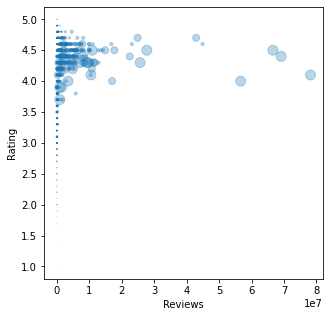

In [26]:
X = df2['Reviews'].values # axis x
Y = df2['Rating'].values # axis y
area = playstore['Installs'].values/10000000 # ukuran besar/kecilnya lingkaran scatter plot
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
# isi nama method untuk scatter plot, variabel x, dan variabel y
plt.scatter(x=X,y=Y, s=area, alpha=0.3)
plt.xlabel('Reviews')
plt.ylabel('Rating')
plt.savefig('rev_rat.png',bbox_inches="tight")

**Membuat Histogram Size Distribution**

**_Task 9:_** Buatlah sebuah histogram yang menggambarkan distribusi Size aplikasi dalam satuan Mb(Megabytes). Histogram yang terbentuk terbagi menjadi 100 bins

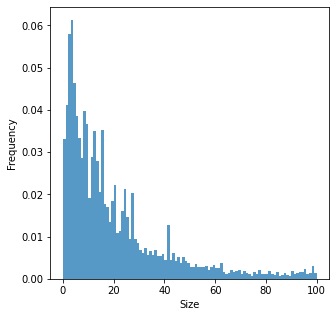

In [27]:
X=((df2['Size'])/1000000).values
fig = plt.figure(figsize=(5,5))
fig.add_subplot()
plt.hist(X,bins=100, density=True,  alpha=0.75)
plt.xlabel('Size')
plt.ylabel('Frequency')
plt.savefig('hist_size.png',bbox_inches="tight")

**_Task 10:_** Buatlah plot berdasarkan hasil analisis anda. Plot yang dibuat tidak diperbolehkan sama dengan plot yang sudah dicontohkan.

C:\Users\USER\AppData\Local\Temp/ipykernel_9056/1520982401.py:12: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.bar(X, Y, color=my_colors)


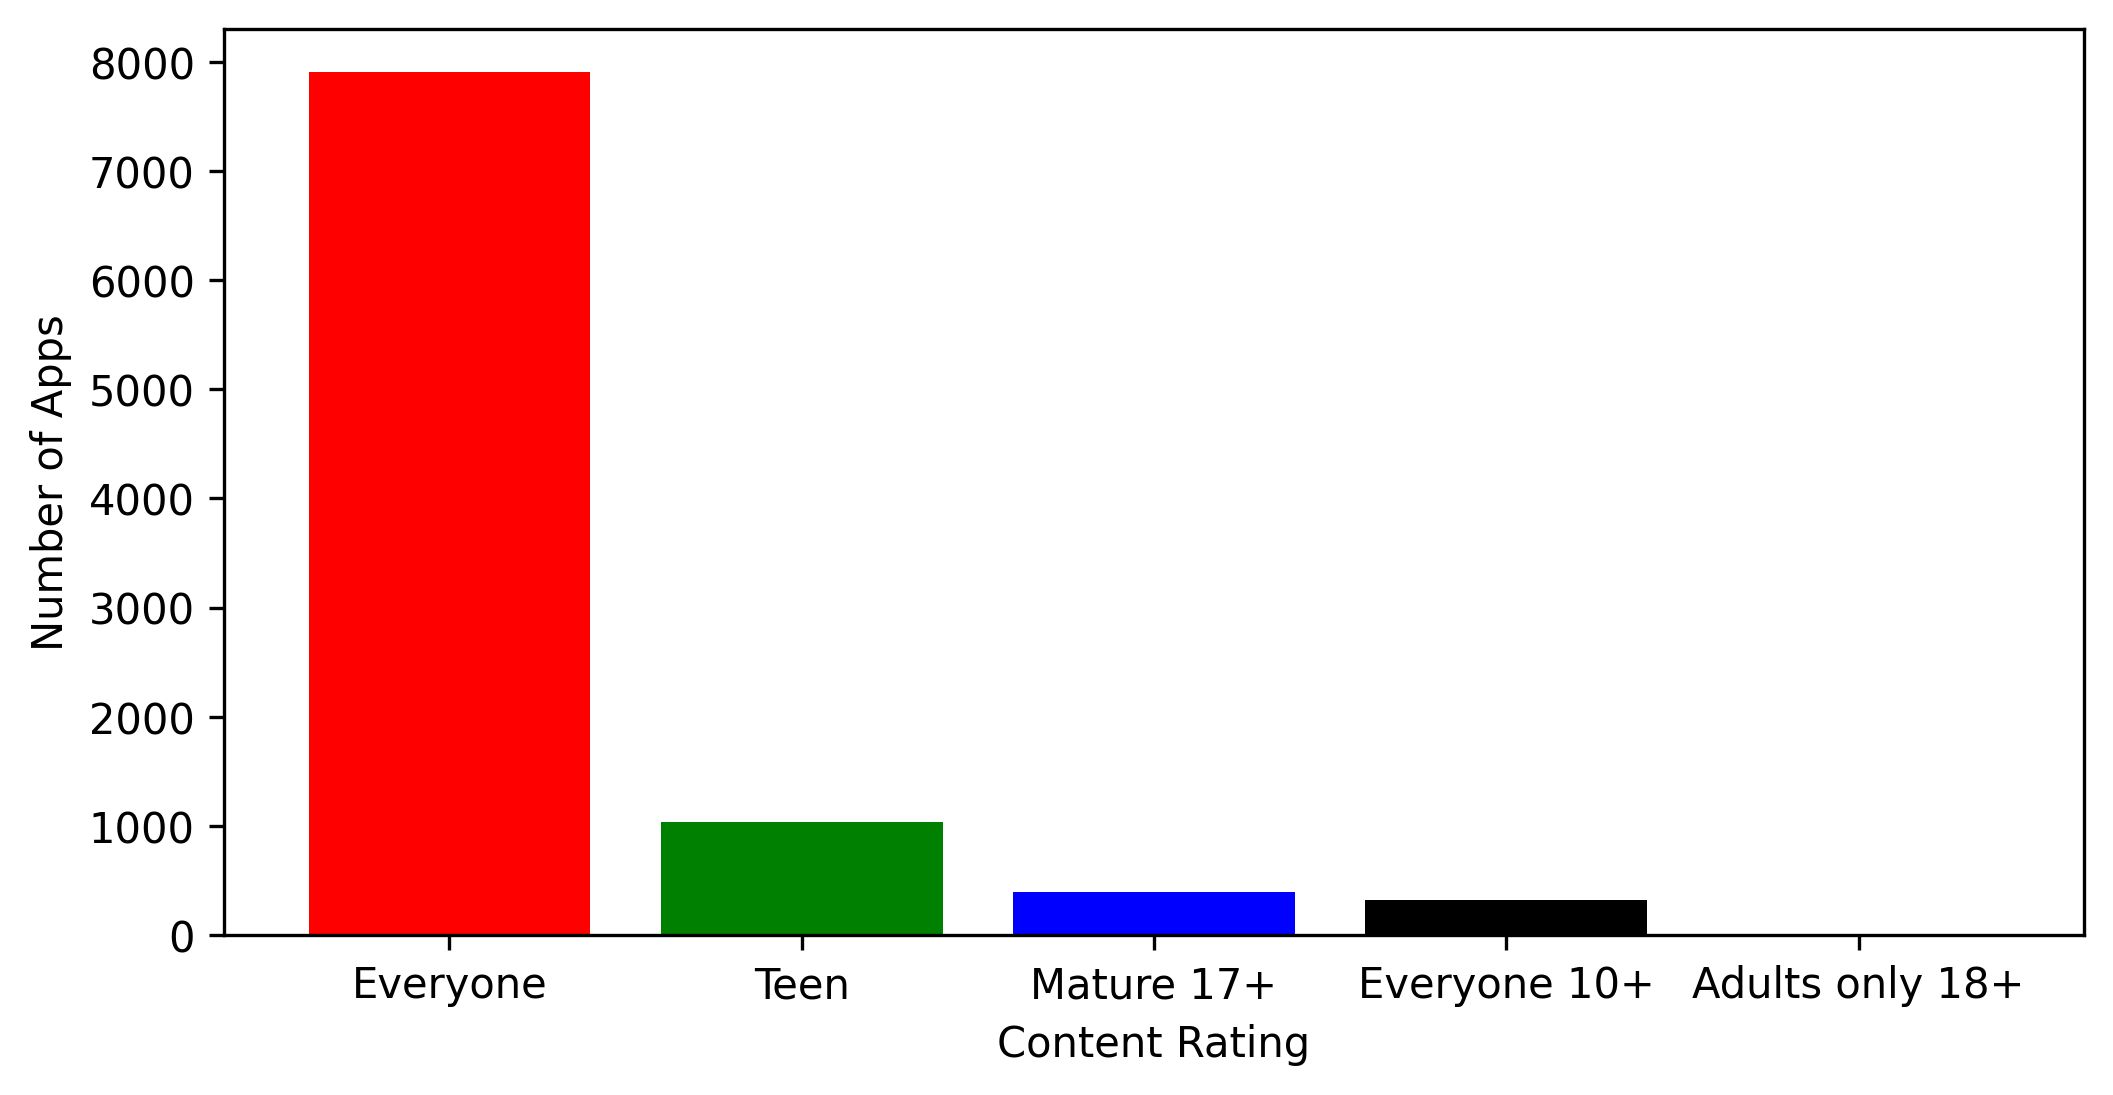

In [30]:
## code here
cr_order = df2.groupby('Content Rating').agg({'App' : 'count'}).rename({'App':'Total'}, axis=1).sort_values('Total',ascending=False).head()
X = cr_order.index
Y = cr_order['Total']
my_colors = 'rgbkymc'
# bagian ini digunakan untuk membuat kanvas/figure
fig = plt.figure(figsize=(8,4),dpi=300)
fig.add_subplot()
# bagian ini digunakan untuk membuat bar plot
plt.xlabel("Content Rating")
plt.ylabel("Number of Apps")
plt.bar(X, Y, color=my_colors)
# bagian ini digunakan untuk menyimpan plot dalam format image.png
plt.savefig('cr_order.png',bbox_inches="tight") 



In [29]:
cr_order

,Total
Content Rating,
Everyone,7903
Teen,1036
Mature 17+,393
Everyone 10+,322
Adults only 18+,3
